### Importing Relevant Libraries

Base Models for comparison
- https://www.kaggle.com/code/ebrahimelgazar/vision-transformer-vit-keras-pretrained-models#1---ViT-B16-Model

https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [2]:
import pandas as pd
import cv2
import os.path
from PIL import Image
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
import os
import glob
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow import keras 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys
print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__))
print("tensorflow version {}".format(tf.__version__))
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "0"
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
#from utils import combine_images
from PIL import Image
#from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import os
import argparse
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
K.set_image_data_format('channels_last')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import logging
# Set TensorFlow logging level to only display errors
tf.get_logger().setLevel(logging.ERROR)

python 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
keras version 2.11.0
tensorflow version 2.11.0


In [3]:
#!pip install tensorflow_addons

### Prepare The Dataset

### DataSet Sources

- https://www.kaggle.com/datasets/mehradaria/covid19-lung-ct-scans
- https://www.kaggle.com/datasets/plameneduardo/sarscov2-ctscan-dataset

- 2,476 items (Covid-CT Scan)
- 2,173 items (Non-Covid-CT Scan)

In [4]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))

path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset_merged/CT_NonCOVID/'
prefix2 = 'ct_noncovid'

def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df


ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
display(cvd_imgs_dataset)

input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((4649,300,300,1))
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
#cvd_imgs_dataset = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
#output_label_y = np.array(cvd_imgs_dataset[['output_encode_0','output_encode_1']])
output_label_y = np.array(cvd_imgs_dataset[['output_encode']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))

,0,1,2,3,4,5,6,7,8,9,...,89991,89992,89993,89994,89995,89996,89997,89998,89999,class_label
COVID-19_0516.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Covid (966).png,231,231,233,235,235,233,230,232,234,235,...,254,255,255,254,251,255,255,255,255,1
Non-Covid (1084).png,63,72,68,67,70,69,64,63,70,58,...,253,253,253,253,253,254,254,254,254,0
COVID-19_0548.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Covid (207).png,202,203,208,208,204,200,212,210,208,216,...,255,255,255,255,248,217,216,209,217,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
COVID-19_0167.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
COVID-19_0313.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Covid (584).png,204,204,204,204,204,204,205,206,207,207,...,212,211,210,209,213,213,213,210,211,1
Covid (1193).png,65,68,68,68,68,68,68,68,65,67,...,215,220,224,224,216,193,122,98,89,1


Input_x Data Shape: 
(4649, 300, 300, 1)
Output_y Data Shape: 
(4649, 1)


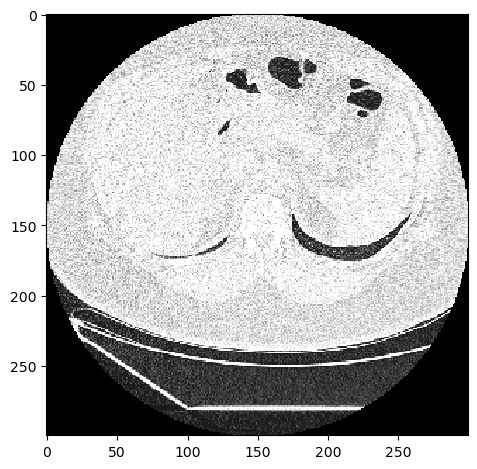

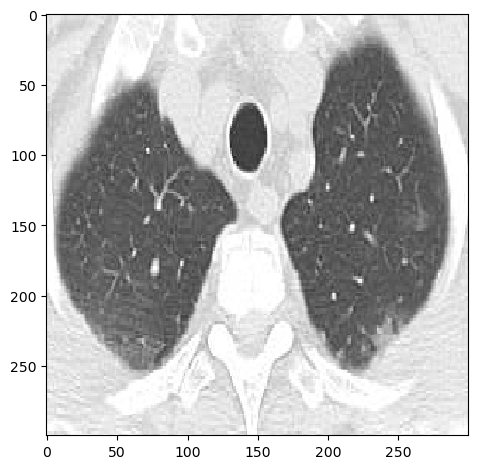

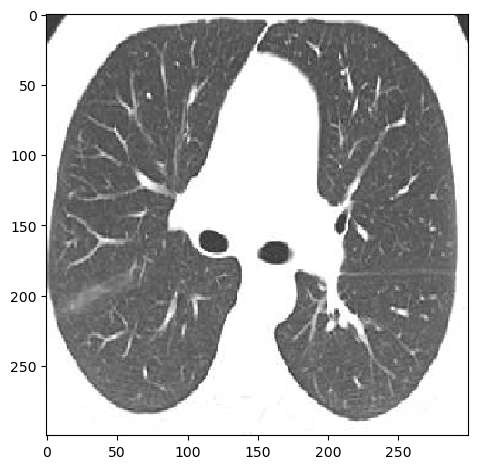

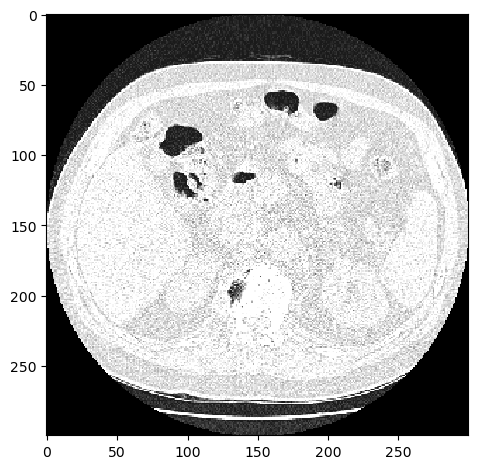

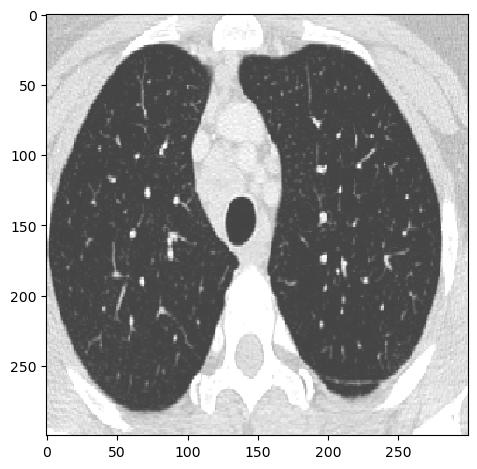

In [5]:
for i in range(5):
    imshow(input_data_x[i])
    show()

### Splitting Data into Training and Test

In [6]:
from sklearn.model_selection import train_test_split
def splitData(input_data_x_, output_label_y_):
    x_train, x_test, y_train, y_test = train_test_split(input_data_x_, output_label_y_, test_size=.20, random_state=42)
    return (x_train, x_test), (y_train, y_test)

In [7]:
def get_data():
    # the data, shuffled and split between train and test sets
    from tensorflow.keras.datasets import mnist
    (x_train, x_test), (y_train, y_test) = splitData(input_data_x, output_label_y)
    #return x_train, x_test, y_train, y_test

    x_train = x_train[0:3700,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    x_test = x_test[0:920,:].reshape(-1, 300, 300, 1).astype('float32') / 255.
    y_train = y_train.astype('float32')[0:3700,:]#4000
    y_test = y_test.astype('float32')[0:920,:]
    return (x_train, y_train), (x_test, y_test)

In [8]:
num_classes = 2
input_shape = (300, 300,1)
# load data
(x_train, y_train), (x_test, y_test) = get_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#(3254, 300, 300, 1) (3254, 2) (1395, 300, 300, 1) (1395, 2)

x_train shape: (3700, 300, 300, 1) - y_train shape: (3700, 1)
x_test shape: (920, 300, 300, 1) - y_test shape: (920, 1)


In [9]:
# y_train = np.array([[i.argmax()] for i in y_train])
# y_test = np.array([[i.argmax()] for i in y_test])

In [10]:
y_test.shape

(920, 1)

#### Configure the hyperparameters

In [11]:
learning_rate = 0.001
weight_decay = 0.001#0.0001
batch_size = 32
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  #15 Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


### Use data augmentation

In [32]:
seed = 42
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal",seed = seed),
        layers.RandomRotation(factor=0.02,seed = seed),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2,seed = seed
        ),
    ],
    name="data_augmentation",
)
# data_augmentation.layers[0].adapt(x_train)

In [13]:
import dill
import weakref

In [14]:
#dill.dump(data_augmentation, open('data_augmentation.pkl', 'wb'))

In [15]:
# # Load the configuration from the pickle file
with open('data_augmentation.pkl', 'rb') as file:
    data_augmentation = dill.load(file)

2023-08-25 09:44:54.336809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 09:44:56.012004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14759 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:19:00.0, compute capability: 7.5
2023-08-25 09:44:56.012666: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14759 MB memory:  -> device: 1, name: Quadro RTX 5000, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-08-25 09:44:56.013180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/tas

In [33]:
data_augmentation.layers[0].adapt(x_train)

### Function for Explaining Model Outcome

In [17]:
def GRADCAM_plus_plus_Superimpose_v2(layerb4classificationModel_idx,model,model_gen,x_test,y_test,startIdx,endIdx):
    '''
    layerb4classificationModel_idx = last convolutional layer before the global/Max pooling and classification layer
    model = classification model
    x_test,y_test = test data set
    startIdx,endIdx = start and finish idx of interest
    '''
    # Get the last convolutional layer before the global pooling and classification layer
    last_conv_layer = model.get_layer(model.layers[layerb4classificationModel_idx].name)#'layer_normalization_1'
    
    # Get the last convolutional layer before the global pooling and classification layer (Generalized Model)
    last_conv_layer_gen = model_gen.get_layer(model_gen.layers[layerb4classificationModel_idx].name)#'layer_normalization_1'
    
    # Load your preprocessed testing dataset (X_test) and corresponding labels (y_test)
    # X_test should be a numpy array of preprocessed images
    # y_test should be a numpy array of corresponding labels

    # Iterate over the testing dataset
    for img_array, true_label in zip(x_test[startIdx:endIdx,:],y_test[startIdx:endIdx,:]):
        # Convert the numpy array to a TensorFlow tensor
        img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
        img_tensor_gen = tf.convert_to_tensor(img_array, dtype=tf.float32)
#         if img_tensor.shape == (300,300,1):
#             img_tensor_gen = img_tensor[tf.newaxis, ...]#np.expand_dims(img_tensor, axis=0)

        # Create a model that maps the input image tensor to the activations of the last convolutional layer
        conv_model = tf.keras.Model(inputs=model.input, outputs=last_conv_layer.output)
        conv_model_gen = tf.keras.Model(inputs=model_gen.input, outputs=last_conv_layer_gen.output)#(Generalized Model)

        # Get the activations of the last conv layer for the input image
        conv_output = conv_model(img_tensor)
        conv_output_gen = conv_model_gen(img_tensor_gen)

        # Get the predicted class index
        predicted_class = np.argmax(model.predict(np.expand_dims(img_array, axis=0)))
        predicted_class_gen = np.argmax(model_gen.predict(np.expand_dims(img_array, axis=0)))

        # Calculate the gradients of the predicted class with respect to the conv_output
        with tf.GradientTape() as tape:
            tape.watch(conv_output)
            target_class_output = conv_output[0, ..., predicted_class]
        grads = tape.gradient(target_class_output, conv_output)
        
        with tf.GradientTape() as tape:
            tape.watch(conv_output_gen)
            target_class_output = conv_output_gen[0, ..., predicted_class_gen]
        grads_gen = tape.gradient(target_class_output, conv_output_gen)

        # Calculate the guided gradients (ReLU of the gradients)
        guided_grads = tf.where(grads > 0, grads, 0)
        guided_grads_gen = tf.where(grads_gen > 0, grads_gen, 0)

        # Calculate the weights for Grad-CAM++
        weights = tf.reduce_mean(guided_grads, axis=(0, 1))
        weights_gen = tf.reduce_mean(guided_grads_gen, axis=(0, 1))

        # Calculate the Grad-CAM++ heatmap
        grad_cam_heatmap = tf.reduce_sum(weights * conv_output, axis=-1)
        grad_cam_heatmap_gen = tf.reduce_sum(weights_gen * conv_output_gen, axis=-1)

        # Normalize the heatmap to [0, 1]
        heatmap_normalized = (grad_cam_heatmap - tf.reduce_min(grad_cam_heatmap)) / (tf.reduce_max(grad_cam_heatmap) - tf.reduce_min(grad_cam_heatmap))
        heatmap_normalized_gen = (grad_cam_heatmap_gen - tf.reduce_min(grad_cam_heatmap_gen)) / (tf.reduce_max(grad_cam_heatmap_gen) - tf.reduce_min(grad_cam_heatmap_gen))

            
        # Resize the heatmap to match the original image size
        heatmap_upsampled = tf.image.resize(heatmap_normalized, (img_array.shape[0], img_array.shape[1]))
        heatmap_upsampled_gen = tf.image.resize(heatmap_normalized_gen, (img_array.shape[0], img_array.shape[1]))

        # Convert heatmap to numpy array for visualization
        heatmap_upsampled_np = heatmap_upsampled.numpy()  # Keep all channels
        heatmap_upsampled_np_gen = heatmap_upsampled_gen.numpy()  # Keep all channels

        # Create a colormap with alpha for heatmap
        cmap_with_alpha = plt.cm.jet
        cmap_with_alpha.set_under(color='black', alpha=0)

        # Display the original image and the superimposed heatmap
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))

        #setting meaning for True_label and predicted class
        if true_label.argmax() == 0:
            true_label_decode = 'Non-Covid'
        else:
            true_label_decode = 'Covid'
            
        if predicted_class == 0:
            predicted_class_decode = 'Non-Covid'
        else:
            predicted_class_decode = 'Covid'
            
        if predicted_class_gen == 0:
            predicted_class_gen_decode = 'Non-Covid'
        else:
            predicted_class_gen_decode = 'Covid'

        axes[0].imshow(img_array[..., 0], cmap='gray')  # Display original grayscale image
        #axes[0].set_title(f"True Label: {true_label_decode} \nPredicted: {predicted_class_decode}")
        axes[0].set_title(f"True Label: {true_label_decode}")

        # Display the original grayscale image
        axes[1].imshow(img_array[..., 0], cmap='gray')

        # Superimpose the heatmap with transparency
        heatmap_composite = np.mean(heatmap_upsampled_np, axis=-1)  # Average over heatmap channels
        heatmap_composite_gen = np.mean(heatmap_upsampled_np_gen, axis=-1)  # Average over heatmap channels
        im = axes[1].imshow(heatmap_composite, cmap=cmap_with_alpha, alpha=0.5)
        axes[1].set_title(f"TASK 1 Grad-CAM++ Heatmap\nPredicted: {predicted_class_decode}")
        plt.colorbar(im, ax=axes[1], fraction=0.046, pad=0.01)

        axes[2].imshow(img_array[..., 0], cmap='gray')
        im_gen = axes[2].imshow(heatmap_composite_gen, cmap=cmap_with_alpha, alpha=0.5)
        axes[2].set_title(f"Generalized Model(TASK_1+TASK_2) \nGrad-CAM++ Heatmap\nPredicted: {predicted_class_gen_decode}")
        plt.colorbar(im_gen, ax=axes[2], fraction=0.046, pad=0.01)
        plt.show()
        
def getModelLayer_info(model):
    # Create an empty list to store layer information
    layer_info = []

    # Iterate through model layers and collect information
    for layer in model.layers:
        layer_info.append({
            'Layer Name': layer.name,
            'Layer Type': layer.__class__.__name__,
            'Output Shape': layer.output_shape,
            'Trainable': layer.trainable,
        })

    # Convert layer information to a DataFrame
    layer_df = pd.DataFrame(layer_info)

    # Print the DataFrame
    return layer_df

### Implement multilayer perceptron (MLP)

In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)#tf.nn.gelu
        x = layers.Dropout(dropout_rate)(x)
    return x


### Implement patch creation as a layer

In [19]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Let's display patches for a sample image

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 36


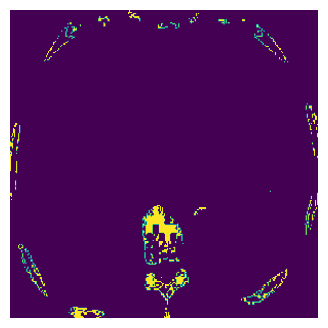

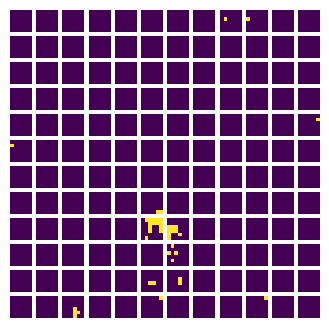

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


### Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


### Build the ViT model

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [35]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model


### Compile, train, and evaluate the mode

In [1]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.001)

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#from_logits=True
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        
    )
    mycallback = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',patience=10,verbose=1,mode='min'),
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=100,#batch_size,
        epochs=120,#num_epochs,
        validation_split=0.10,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy,top_5_accuracy = model.evaluate(x_test, y_test)#top_5_accuracy
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

In [ ]:
dill.dump(history, open('history_VIT.pkl', 'wb'))
# # Load the configuration from the pickle file
# with open('dhistory_VIT.pkl', 'rb') as file:
#     data_augmentation = dill.load(file)

After 100 epochs, the ViT model achieves around 55% accuracy and 82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset, as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset

### Model Evaluation

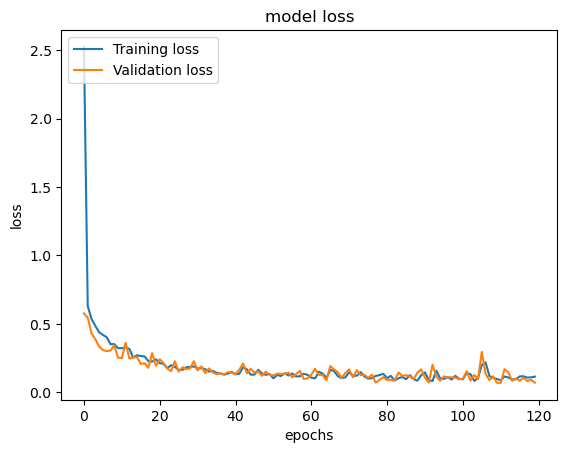

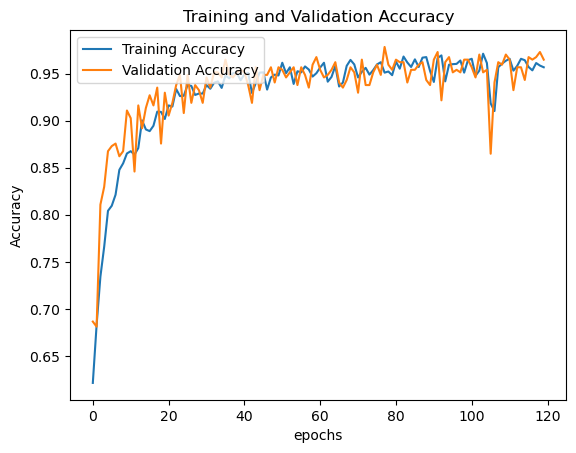

In [30]:
def evaluateModel_loss(history):
    print()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Training loss','Validation loss'], loc = 'upper left')
    plt.savefig("Training_validation_loss_with_i.jpg")
    plt.show()
    plt.close()
    #plt.show()
    print()
def evaluateModel_accuracy(history):
    print()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Training and Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'], loc = 'upper left')
    #plt.show()
    plt.savefig("Training_validation_accuracy_with_i.jpg")
    plt.show()
    plt.close()
    print()
evaluateModel_loss(history)
evaluateModel_accuracy(history)

### Saving Model and Weights

In [31]:
#vit_classifier.save('VIT_model_trial_jordan_aug_1.h5')

In [32]:
vit_classifier.save_weights('VIT_model_weight_trial_jordan_aug_3.h5')

### Testing Model

In [33]:
label_predicted = vit_classifier.predict((x_test))

29/29 [==============================] - 1s 25ms/step


In [34]:
label_predicted.shape

(920, 2)

In [35]:
x_test.shape

(920, 300, 300, 1)

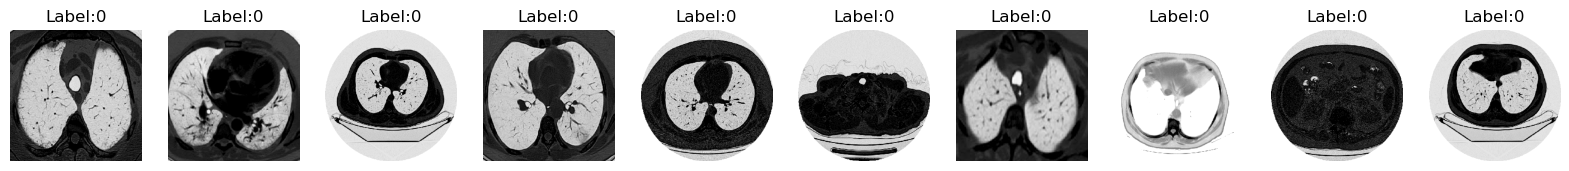

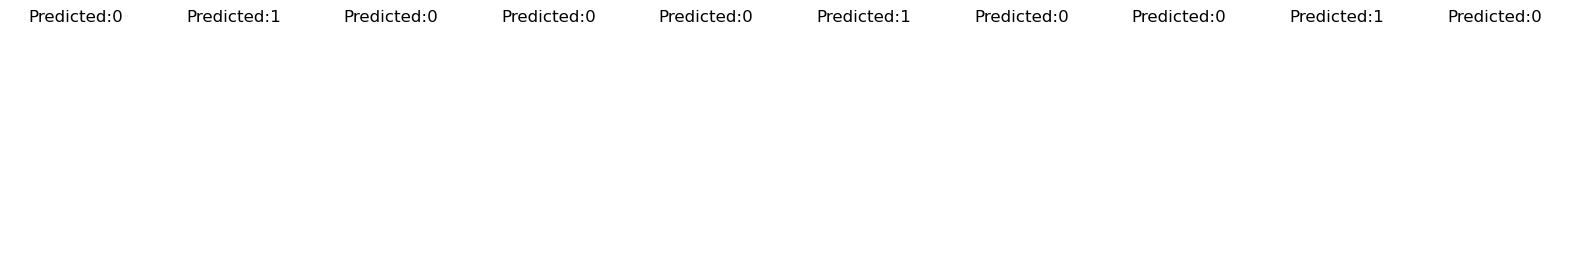

In [36]:
n_samples = 10

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = x_test[index].reshape(300, 300)
    plt.imshow(sample_image, cmap="binary")
    plt.title("Label:" + str(y_test[index].argmax()))
    plt.axis("off")

plt.show()

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    #sample_image = image_predicted[index].reshape(300, 300)
    #plt.imshow(sample_image, cmap="binary")
    plt.title("Predicted:" + str(np.argmax(label_predicted[index])))
    plt.axis("off")

plt.show()

In [23]:
def getCorrectLabel(x):
        if x == 0:
            return 'Non-Covid'
        if x == 1:
            return 'Covid'
        
def D1_to_D2(y_pred):
    y_true = {'y_true':[i[0] for i in y_pred]}
    y_true_df = pd.DataFrame(y_true)
    y_true_df = pd.get_dummies(y_true_df, columns =['y_true'])
    output_label_y = np.array(y_true_df[y_true_df.columns])
    return output_label_y

def getModelEvaluation(model, test_features_,test_labels_):
    predicted_labels = model.predict(np.stack(test_features_))
    df = pd.DataFrame(predicted_labels)
    df['Predicted_Labels'] = np.array(df.iloc[:,:2]).argmax(axis =1)
    df['Predicted_Labels'] = df['Predicted_Labels'].apply(getCorrectLabel)
    if (test_labels_.shape[1]==2):
        df['Actual_Labels'] = test_labels_[:,:2].argmax(axis = 1)
    else:
        df['Actual_Labels'] = D1_to_D2(test_labels_)[:,:2].argmax(axis = 1)
    df['Actual_Labels'] = df['Actual_Labels'].apply(getCorrectLabel)
    # df['Probality'] = np.max(np.array(df.iloc[:,:7]))
    #df.drop([0,1,2,3,4,5,6,7,8,9],axis =1,inplace=True)
    #print(df.head(100))
    cm = pd.crosstab(df.Predicted_Labels, df.Actual_Labels)
    fig = plt.figure(figsize=(20,5))
    ax1 = plt.subplot(121)
    sns.heatmap(cm,annot = True,cmap='Blues')
    ax1.set_title('')
    # Saving the figure.
    plt.savefig("test_Confusion_Matrix_with_i.jpg")
    plt.show()
    plt.close()
    
    test_labels__ = [int(i[0]) for i in test_labels_]
    pred_list = [i.argmax() for i in predicted_labels]
    count = 0
    for i in range(test_labels_.shape[0]):
        if int(test_labels__[i]) == int(pred_list[i]):
            count+=1
    #pred_list = [i for i in range(test_labels_.shape[0]) if test_labels__[i] is predicted_labels[i]]

#     pred = model.evaluate(test_features_,test_labels_)
#     print("loss = " + str(pred[0]))
    print("test accuracy = " + str((count/test_labels_.shape[0])*100)+'%')
    print('-------------------------------------------------------------------------------------------------')
    print('Model Metrics')
    # getting model predictions
    #test_predictions,_ = model.predict((x_test,y_test),20)
    predictions = pd.DataFrame(predicted_labels)#, columns=labels_ohe_names.columns
    predictions = list(predictions.idxmax(axis=1))
    #test_labels__ = [i.argmax() for i in test_labels_]

    # evaluate model performance
    import model_evaluation_utils_ as meu
    meu.get_metrics(true_labels=test_labels__, 
                    predicted_labels=predictions)
    

In [39]:
#!pip install seaborn

29/29 [==============================] - 1s 25ms/step


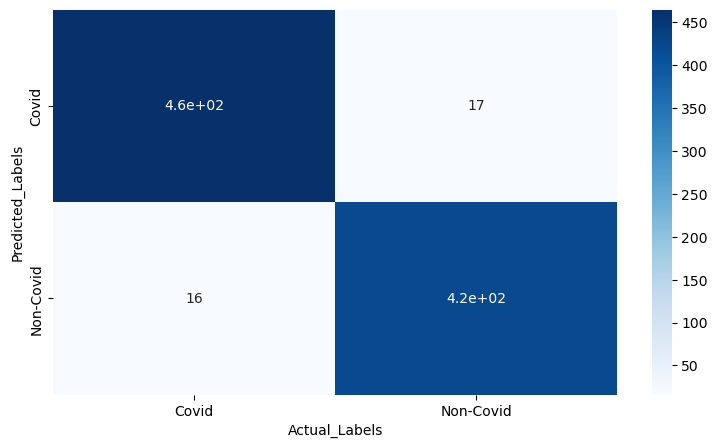

test accuracy = 96.41304347826087%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.9641
Precision: 0.9641
Recall: 0.9641
F1 Score: 0.9641


In [40]:
import seaborn as sns
getModelEvaluation(vit_classifier,x_test,y_test)

In [41]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 1  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 72, 72, 1)   3           ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 36)     0           ['data_augmentation[0][0]']      
                                                                                                  
 patch_encoder (PatchEncoder)   (None, 144, 64)      11584       ['patches_1[0][0]']          

                                                                                                  
 multi_head_attention_3 (MultiH  (None, 144, 64)     66368       ['layer_normalization_6[0][0]',  
 eadAttention)                                                    'layer_normalization_6[0][0]']  
                                                                                                  
 add_6 (Add)                    (None, 144, 64)      0           ['multi_head_attention_3[0][0]', 
                                                                  'add_5[0][0]']                  
                                                                                                  
 layer_normalization_7 (LayerNo  (None, 144, 64)     128         ['add_6[0][0]']                  
 rmalization)                                                                                     
                                                                                                  
 dense_7 (

 dense_14 (Dense)               (None, 144, 64)      8256        ['dropout_12[0][0]']             
                                                                                                  
 dropout_13 (Dropout)           (None, 144, 64)      0           ['dense_14[0][0]']               
                                                                                                  
 add_13 (Add)                   (None, 144, 64)      0           ['dropout_13[0][0]',             
                                                                  'add_12[0][0]']                 
                                                                                                  
 layer_normalization_14 (LayerN  (None, 144, 64)     128         ['add_13[0][0]']                 
 ormalization)                                                                                    
                                                                                                  
 multi_hea

In [42]:
from keras.utils.vis_utils import plot_model

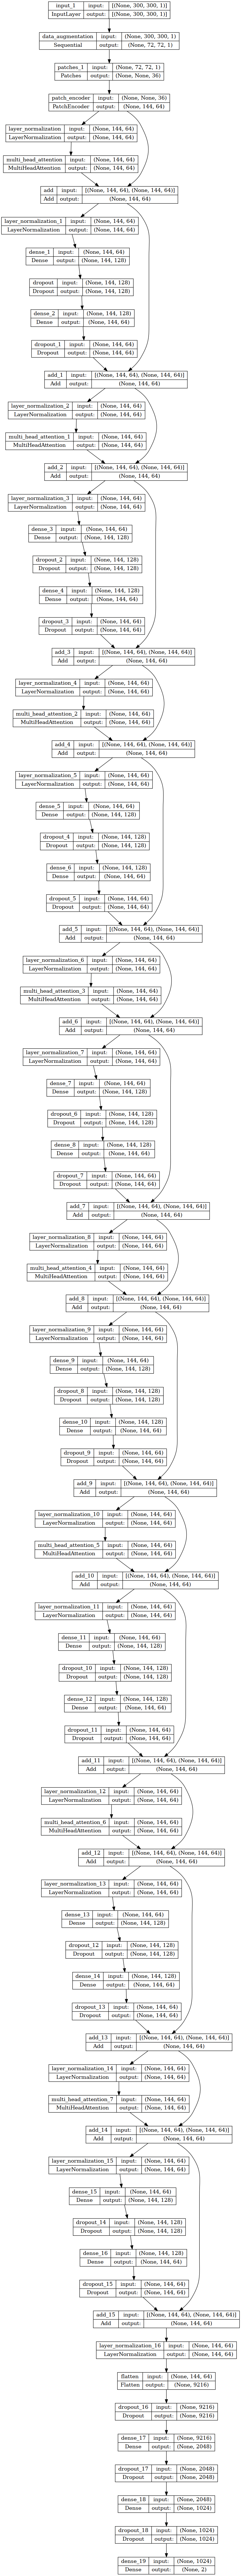

In [43]:
plot_model(vit_classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Testing the Trained Model on a different Dataset
- https://www.kaggle.com/datasets/maedemaftouni/large-covid19-ct-slice-dataset

In [24]:
def renameImageFiles(folderpath, prefix,fileExtension):
    folder_path = folderpath
    new_prefix = prefix

    for i, file_path in enumerate(glob.glob(folder_path + '*.'+fileExtension)):
        new_file_name = new_prefix + '_' + str(i+1) + '.'+fileExtension
        os.rename(file_path, os.path.join(folder_path, new_file_name))


path1 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_COVID/'
prefix1 = 'ct_covid'
path2 = '/home/rkannan/Desktop/Cvd19_Classification/dataset/dataset2/CT_NonCOVID/'
prefix2 = 'ct_noncovid'

def processImage(imgDirPath,binary_label):
    img_names = list()
    with os.scandir(imgDirPath) as dirs:
        for entry in dirs:
            img_names.append(entry.name)
    #Creating features for images
    all_features = []
    for img in img_names:
        path = imgDirPath + img
        cv_img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        cv_img2 = cv2.resize(cv_img, (300, 300), interpolation=cv2.INTER_NEAREST)
        #create features for machine learning
        nFeatures = (cv_img2.shape[0]*cv_img2.shape[1])
        features = np.reshape(cv_img2, nFeatures)
        all_features.append(features)
        #print(features.shape)
    imgs_df = pd.DataFrame(np.array(all_features), index=img_names)
    if binary_label == 0:
        imgs_df['class_label'] = np.zeros((imgs_df.shape[0]),dtype=int)
    else:
        imgs_df['class_label'] = np.ones((imgs_df.shape[0]),dtype=int)
    return imgs_df


ct_covid_features_df =  processImage(path1,1)#1--> covid-19 positive
ct_noncovid_features_df =  processImage(path2,0)#0 ---> covnid-19 negative
cvd_imgs = [ct_noncovid_features_df, ct_covid_features_df]
cvd_imgs_dataset = pd.concat(cvd_imgs)
for i in range(100):
    # shuffle the DataFrame rows
    cvd_imgs_dataset = cvd_imgs_dataset.sample(frac = 1)
display(cvd_imgs_dataset)

input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy().reshape((14486,300,300,1))
#input_data_x = cvd_imgs_dataset.iloc[:,:-1].to_numpy()
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
cvd_imgs_dataset['output_encode'] = label_encoder.fit_transform(cvd_imgs_dataset['class_label'])
cvd_imgs_dataset
#cvd_imgs_dataset_ = pd.get_dummies(cvd_imgs_dataset, columns =['output_encode'])
##Getting the input_labels and input_features for training and testing model
#output_label_y_eval = np.array(cvd_imgs_dataset_[['output_encode_0','output_encode_1']])
output_label_y = np.array(cvd_imgs_dataset[['output_encode']])
# print('Input_x Data: \n{0}'.format(input_data_x))
# print('Output_y Data: \n{0}'.format(output_label_y))
print('Input_x Data Shape: \n{0}'.format(input_data_x.shape))
print('Output_y Data Shape: \n{0}'.format(output_label_y.shape))
#print('Output_y Data Shape for evaluation: \n{0}'.format(output_label_y_eval.shape))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


,0,1,2,3,4,5,6,7,8,9,...,89991,89992,89993,89994,89995,89996,89997,89998,89999,class_label
ct_noncovid_5029.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_covid_4280.png,0,3,0,3,3,1,6,0,10,4,...,0,0,3,5,0,0,4,1,3,1
ct_covid_1442.png,255,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,255,1
ct_covid_4205.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ct_covid_4769.png,0,2,2,2,2,5,0,3,4,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ct_covid_3301.png,0,0,0,0,0,0,0,0,0,0,...,3,0,0,3,2,2,3,2,1,1
ct_noncovid_377.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ct_covid_1831.png,0,0,0,0,0,0,0,0,0,0,...,0,1,9,8,0,2,2,0,0,1
ct_noncovid_670.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Input_x Data Shape: 
(14486, 300, 300, 1)
Output_y Data Shape: 
(14486, 1)


In [25]:
y_test_new = output_label_y
x_test_new = input_data_x

In [26]:
from sklearn.model_selection import train_test_split

train_features_gen_2, test_features_gen_2, train_labels_gen_2, test_labels_gen_2 = train_test_split(
    input_data_x, output_label_y, test_size=.50, random_state=42)

# train_features_gen_2, val_features_gen_2, train_labels_gen_2, val_labels_gen_2 = train_test_split(
#     train_features_gen_2, train_labels_gen_2, test_size=.20, random_state=42)

### Testing Originnal Model on new dataset

### Load Saved Model

In [1]:
num_classes = 2
input_shape = (300, 300)
vit_classifier = create_vit_classifier()
vit_classifier.compile(
            optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#from_logits=True
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
vit_classifier.load_weights('VIT_model_weight_trial_jordan_1.h5')

In [36]:
model = tf.keras.models.load_model('VIT_model.h5')

91/91 [==============================] - 2s 23ms/step


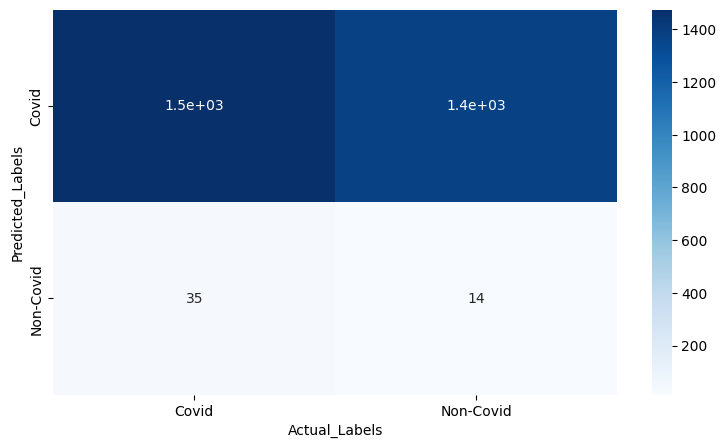

test accuracy = 51.38026224982747%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.5138
Precision: 0.4066
Recall: 0.5138
F1 Score: 0.362


In [186]:
getModelEvaluation(vit_classifier,test_features_gen_2,test_labels_gen_2)

### Transfer Learning Approach Using Pre-trained weights from Task 1

### Generaliing the Model on new Dataset 1

In [105]:
num_classes = 2
input_shape = (300, 300)
vit_classifier_gen = create_vit_classifier()
vit_classifier_gen.compile(
            optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#from_logits=True
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
vit_classifier_b4_gen.load_weights('VIT_model_weight_trial_jordan_1.h5')

In [106]:
layers__ = [(layer, layer.name, layer.trainable) for layer in vit_classifier_b4_gen.layers]
pd.DataFrame(layers__, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_12,True
1,<keras.engine.sequential.Sequential object at ...,data_augmentation,False
2,<__main__.Patches object at 0x7f6244518fd0>,patches_13,True
3,<__main__.PatchEncoder object at 0x7f624d94cc70>,patch_encoder_11,True
4,<keras.layers.normalization.layer_normalizatio...,layer_normalization_187,True
...,...,...,...
79,<keras.layers.core.dense.Dense object at 0x7f6...,dense_245,True
80,<keras.layers.regularization.dropout.Dropout o...,dropout_234,True
81,<keras.layers.core.dense.Dense object at 0x7f6...,dense_246,True
82,<keras.layers.regularization.dropout.Dropout o...,dropout_235,True


In [138]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.001)
    model_ = model
    # Step 2: Identify the layers to keep (e.g., excluding the last fully connected layer)
    layers_to_keep = model_.layers[0:]
    
        #getting the input and output tensor from old model to create new model_without fully connected layers
    input_tensor = model_.input
#     #     # Augment data.
#     input_tensor = data_augmentation(input_tensor)
    output_tensor = layers_to_keep[-1].output
    new_model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    #from keras.utils.vis_utils import plot_model
    # Freeze the pre-trained layers
    for layer in new_model.layers[:-1]:
        layer.trainable = False
    
    #start_new = new_model.output
    # Add new classifier layers
#     representation = tf.keras.layers.Flatten()(start_new)
#     representation = tf.keras.layers.Dropout(0.50)(representation)
    
#     mlp_head_units = [102,204]
#     # Add MLP.
#     features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
#     # Classify outputs.
#     logits = layers.Dense(num_classes)(features)
    
    # Create the Keras model.
    model_ = new_model#tf.keras.Model(inputs=input_tensor, outputs=logits)
    model_.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#from_logits=True
        metrics=[
            tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
        
    )
    mycallback = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',patience=5,verbose=1,mode='min'),
    history = model_.fit(
        x=train_features_gen_2,
        y=train_labels_gen_2,
        batch_size=100,#batch_size,
        epochs=100,#num_epochs,
        validation_data=(val_features_gen_2, val_labels_gen_2),#validation_split=0.10,
        callbacks=[checkpoint_callback,mycallback],
    )

    #model.load_weights(checkpoint_filepath)
    _, accuracy,top_5_accuracy = model.evaluate(test_features_gen_2, test_labels_gen_2)#top_5_accuracy
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history,model_
    #return model_

In [139]:
history_gen,vit_classifier_after_gen = run_experiment(vit_classifier_gen)

Epoch 1/100
93/93 [==============================] - 91s 913ms/step - loss: 1.0252 - accuracy: 0.6162 - top-5-accuracy: 1.0000 - val_loss: 0.5874 - val_accuracy: 0.7640 - val_top-5-accuracy: 1.0000
Epoch 2/100
93/93 [==============================] - 83s 898ms/step - loss: 0.6922 - accuracy: 0.6895 - top-5-accuracy: 1.0000 - val_loss: 0.5773 - val_accuracy: 0.7558 - val_top-5-accuracy: 1.0000
Epoch 3/100
93/93 [==============================] - 83s 896ms/step - loss: 0.6035 - accuracy: 0.7131 - top-5-accuracy: 1.0000 - val_loss: 0.5577 - val_accuracy: 0.7580 - val_top-5-accuracy: 1.0000
Epoch 4/100
93/93 [==============================] - 83s 896ms/step - loss: 0.5862 - accuracy: 0.7225 - top-5-accuracy: 1.0000 - val_loss: 0.5942 - val_accuracy: 0.7299 - val_top-5-accuracy: 1.0000
Epoch 5/100
93/93 [==============================] - 84s 907ms/step - loss: 0.5887 - accuracy: 0.7193 - top-5-accuracy: 1.0000 - val_loss: 0.5584 - val_accuracy: 0.7748 - val_top-5-accuracy: 1.0000
Epoch 6/10

In [140]:
layers__ = [(layer, layer.name, layer.trainable) for layer in vit_classifier_after_gen.layers]
pd.DataFrame(layers__, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at...,input_13,False
1,<keras.engine.sequential.Sequential object at ...,data_augmentation,False
2,<__main__.Patches object at 0x7f6243961bb0>,patches_14,False
3,<__main__.PatchEncoder object at 0x7f61c889cca0>,patch_encoder_12,False
4,<keras.layers.normalization.layer_normalizatio...,layer_normalization_204,False
...,...,...,...
79,<keras.layers.core.dense.Dense object at 0x7f6...,dense_271,False
80,<keras.layers.regularization.dropout.Dropout o...,dropout_259,False
81,<keras.layers.core.dense.Dense object at 0x7f6...,dense_272,False
82,<keras.layers.regularization.dropout.Dropout o...,dropout_260,False


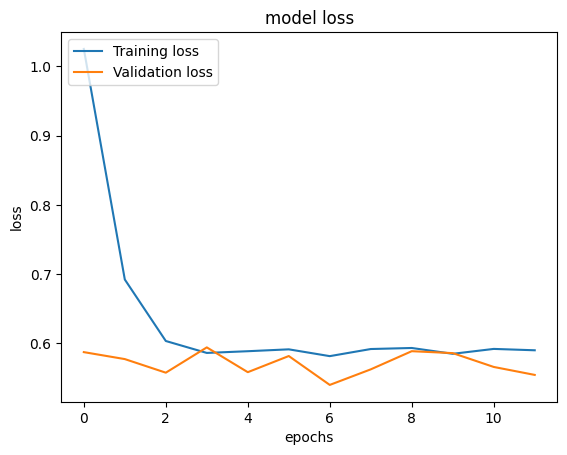

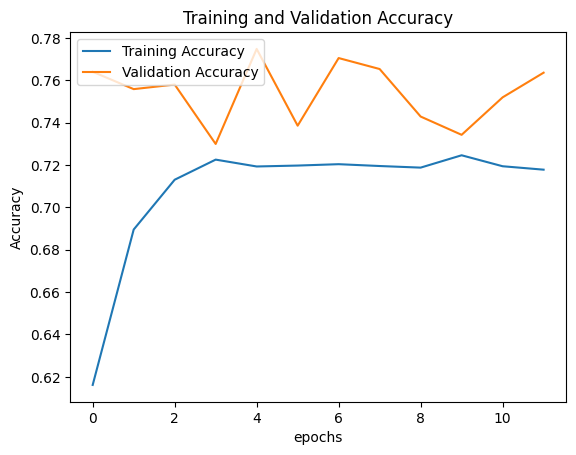

In [141]:
evaluateModel_loss(history_gen)
evaluateModel_accuracy(history_gen)

In [148]:
vit_classifier_after_gen.save_weights('VIT_model_gen_weight_trial_jordan_1.h5')

In [150]:
num_classes = 2
input_shape = (300, 300)
vit_classifier_after_gen_ = create_vit_classifier()
vit_classifier_after_gen_.compile(
            optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),#from_logits=True
            metrics=[
                tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
vit_classifier_after_gen_.load_weights('VIT_model_gen_weight_trial_jordan_1.h5')

91/91 [==============================] - 2s 23ms/step


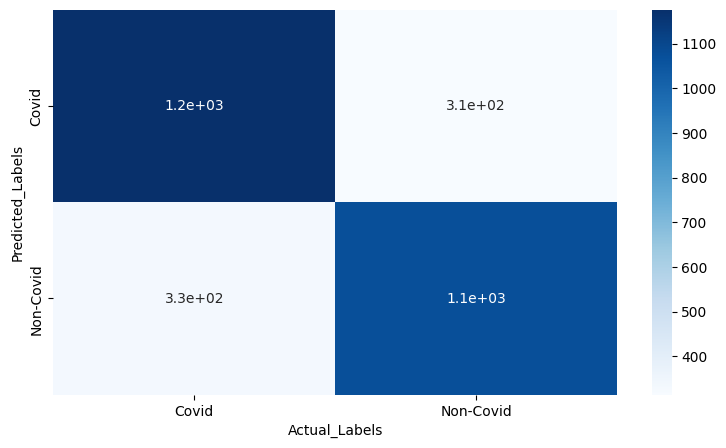

test accuracy = 77.63975155279503%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.7764
Precision: 0.7766
Recall: 0.7764
F1 Score: 0.7765


In [185]:
getModelEvaluation(vit_classifier_after_gen_,test_features_gen_2,test_labels_gen_2)

### Testing the Generalized Model on the Old Test data for previous model training 

19/19 [==============================] - 1s 24ms/step


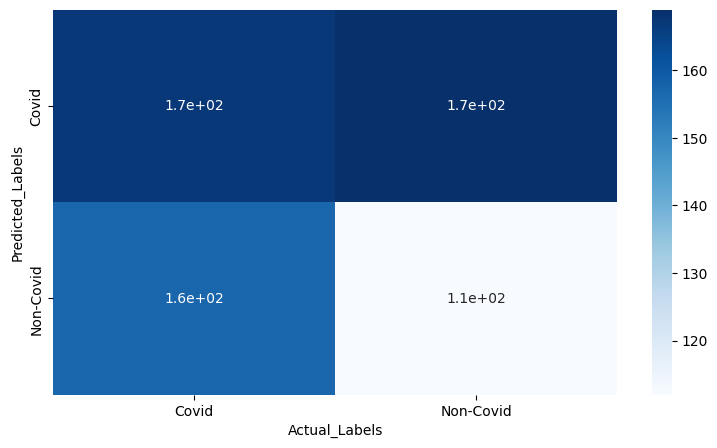

test accuracy = 46.11570247933884%
-------------------------------------------------------------------------------------------------
Model Metrics
Accuracy: 0.4612
Precision: 0.4596
Recall: 0.4612
F1 Score: 0.4602


In [184]:
getModelEvaluation(vit_classifier_after_gen_,x_test,y_test)